In [1]:
#!pip install cryptocmd

In [2]:
import yfinance as yf
from cryptocmd import CmcScraper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [4]:
ticker=['btc', 'eth', 'xrp', 'matic', 'sol', 'ada', 'dai', 'link', 'doge', 'shib','dot', 'ltc']
crypto=[]
for ticker in ticker:
    scraper = CmcScraper(ticker, '18-01-2023', '18-01-2023')
    df = scraper.get_dataframe()
    df['coin']=ticker
    crypto.append(df)
crypto_mkt = pd.concat(crypto).reset_index(drop=True)
crypto_mkt['coin']=crypto_mkt['coin'].str.upper()

In [5]:
crypto_mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        12 non-null     datetime64[ns]
 1   Open        12 non-null     float64       
 2   High        12 non-null     float64       
 3   Low         12 non-null     float64       
 4   Close       12 non-null     float64       
 5   Volume      12 non-null     float64       
 6   Market Cap  12 non-null     float64       
 7   coin        12 non-null     object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 896.0+ bytes


In [6]:
#Make some adjustments on crypto_mkt
col=['Open', 'High', 'Low', 'Volume']
crypto_mkt.drop(columns=col, inplace=True)
crypto_mkt['Market Cap']/=1e6
market_cap=crypto_mkt[['Market Cap', 'coin']]
market_cap.set_index('coin')

,Market Cap
coin,
BTC,398593.008037
ETH,185458.451766
XRP,19243.271452
MATIC,8211.312102
SOL,7732.679757
ADA,11295.307182
DAI,5814.924312
LINK,3225.837041
DOGE,10638.963800


In [7]:
crypto_mkt['Number of coins']=crypto_mkt['Market Cap'].div(crypto_mkt['Close'])
crypto_mkt.drop(columns=['Close', 'Market Cap', 'Date'], inplace=True)

In [8]:
# initialise scraper without time interval for max historical data

ticker=['btc', 'eth', 'xrp', 'matic', 'sol', 'ada', 'dai', 'link', 'doge', 'shib','dot', 'ltc']
crypto=[]
for ticker in ticker:
    scraper = CmcScraper(ticker, '1-1-2021', '1-1-2023')
    df = scraper.get_dataframe()
    df['coin']=ticker
    crypto.append(df)
crypto = pd.concat(crypto)
crypto_data=crypto[['Close', 'coin', 'Date']]

In [9]:
#Mergin crypto data with crypto mkt sow we can hace the market capitalization and the last price
crypto_data['coin'] = crypto_data['coin'].str.upper()
crypto_total=pd.merge(crypto_data, crypto_mkt, how='left', on='coin')

<ipython-input-9-8b6365499202>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crypto_data['coin'] = crypto_data['coin'].str.upper()


In [10]:
#Calculating the market value
crypto_total['market cap']=crypto_total.Close.mul(crypto_total['Number of coins'])

In [11]:
#Pivot the the crypto total_table
crypto_pivot=pd.pivot_table(crypto_total, index='Date', 
                            values='market cap', columns='coin')

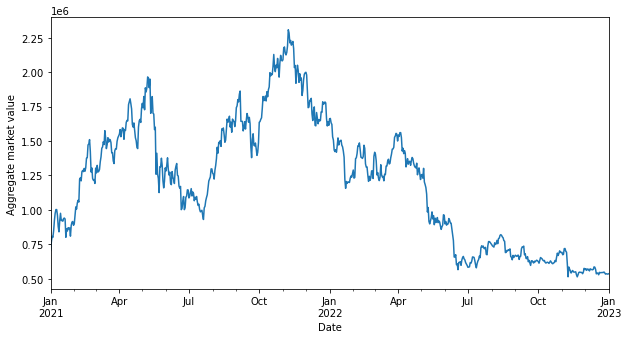

In [12]:
#Calculating the aggregate market value and plotting it
market_value_agg=crypto_pivot.sum(axis=1)
market_value_agg.plot()
_=plt.ylabel('Aggregate market value')
plt.show()

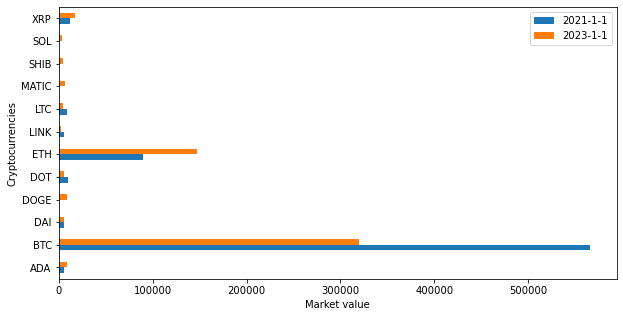

In [13]:
#Comparing the number of coins per cryptocurrency

first_value=crypto_pivot.iloc[0]
last_value=crypto_pivot.iloc[-1]
concat=pd.concat([first_value,last_value], axis=1)

fig, ax=plt.subplots()
concat.plot(kind='barh', ax=ax)
ax.legend(['2021-1-1', '2023-1-1'])
_=plt.ylabel('Cryptocurrencies')
_=plt.xlabel('Market value')
plt.show()

In [14]:
first_value

coin
ADA        6060.030613
BTC      565926.610799
DAI        5844.360632
DOGE        754.227988
DOT        9741.252727
ETH       89377.903195
LINK       6031.257538
LTC        9099.319660
MATIC       155.572955
SHIB          0.092370
SOL         683.156495
XRP       12041.593667
Name: 2021-01-01 00:00:00, dtype: float64

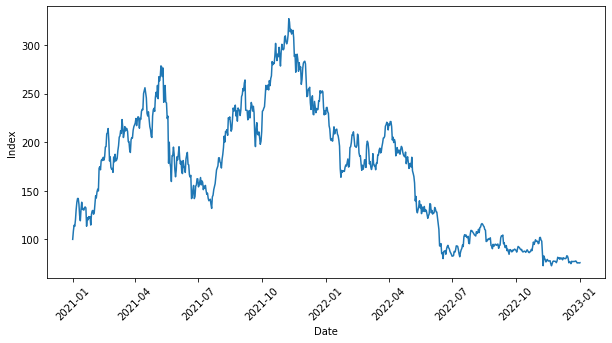

In [15]:
#Normalizing the index to start at 100
index=market_value_agg.div(market_value_agg.iloc[0]).mul(100)

sns.lineplot(data=index)
_=plt.ylabel('Index')
plt.xticks(rotation=45)
plt.show()

# Evaluating the index performance

In [16]:
# Value contribution
print(market_value_agg[-1]-market_value_agg[0])

-169615.03841128224


In [17]:
# Value contribution by cryptocurrency
change=crypto_pivot.first('D').append(crypto_pivot.last('D'))
change.diff().iloc[-1].sort_values().to_frame()

,2023-01-01
coin,
BTC,-245625.431522
DOT,-4615.677363
LTC,-3994.569748
LINK,-3175.056726
DAI,-27.329094
ADA,2571.951642
SOL,3018.838625
SHIB,4460.402550
XRP,5138.223530


In [18]:
#Market cap base-weights
weights=market_cap.groupby('coin')['Market Cap'].sum()/market_cap['Market Cap'].sum()
weights.sort_values().mul(100)

coin
LINK      0.482234
DAI       0.869280
LTC       0.891994
SHIB      0.916582
DOT       0.990144
SOL       1.155968
MATIC     1.227519
DOGE      1.590432
ADA       1.688550
XRP       2.876701
ETH      27.724419
BTC      59.586175
Name: Market Cap, dtype: float64

In [31]:
#Contribution of each crptocurrency to the index return
index_return=(index.iloc[-1]/index.iloc[0]-1)*100
index_return

-24.0344823912389

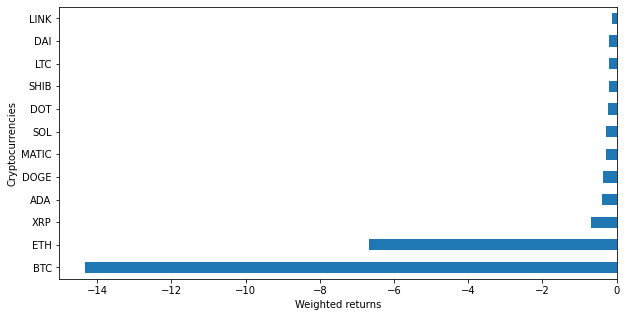

In [20]:
#Value-weighted components return
weighted_returns=weights.mul(index_return)
weighted_returns.sort_values().plot(kind='barh')
_=plt.xlabel('Weighted returns')
_=plt.ylabel('Cryptocurrencies')
plt.show()

# Performance of index against DJIA

In [21]:
#Converting the index series to a DataFrame
cap_index=index.to_frame('Index')

In [22]:
#Import data from sp&500
df_sp500= yf.download( '^DJI', '2021-1-1', '2023-1-1')

#Fixing up the date column
df_sp500.reset_index(inplace=True)
df_sp500['Date'] = df_sp500['Date'].dt.strftime('%Y-%m-%d')

#setting back the index
df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])   
df_sp500.set_index('Date',inplace=True)

#Drop columns I do not need
col=['Open', 'High', 'Low', 'Volume', 'Close']
df_sp500.drop(columns=col, inplace=True)

#Normalizing the sp500 to start at 100
df_sp500['Dow Jones']=df_sp500['Adj Close'].div(df_sp500['Adj Close'].iloc[0], axis=0).mul(100)


[*********************100%***********************]  1 of 1 completed


In [23]:
#Concatening both dataframes

cap_total=pd.concat([cap_index, df_sp500], axis=1)
cap_total.drop(columns='Adj Close', inplace=True)

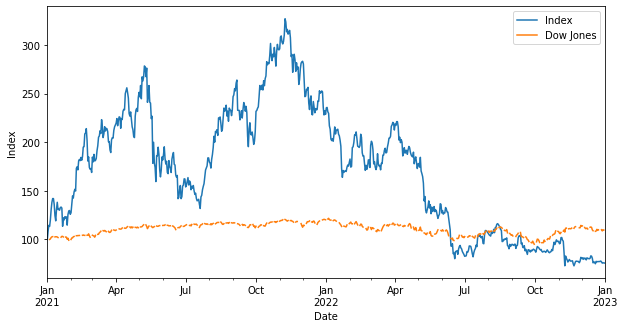

In [24]:
#Plotting the two indicators
cap_total.plot()
_=plt.ylabel('Index')
plt.show()

In [25]:
#Creating a multiperiod  return function
def mlp_return(r):
    return (np.prod(r+1)-1) * 100

# Calculate rolling_return_360 an apply the function to the data
rolling_return_30 = cap_total.pct_change().rolling('30D').apply(mlp_return)

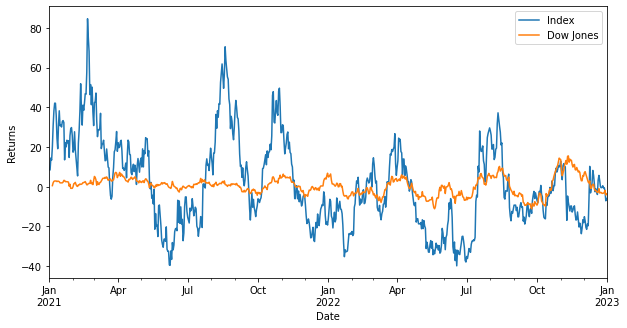

In [26]:
#Plotting the data

#rolling_return_30.plot(title='Rolling 30D Return')
rolling_return_30.plot()
_=plt.ylabel('Returns')
plt.show()


In [41]:
rolling_return_30.tail()

,Index,Dow Jones
Date,,
2022-12-28,-0.520024,-2.876708
2022-12-29,-2.249465,-1.866125
2022-12-30,-7.066696,-4.170365
2022-12-31,-5.873444,-3.627740
2023-01-01,-6.389098,-3.725337


The graph above shows when it was better to invest in our index or the SP500 for a 30 days period

In [27]:
# Looking at the return correlations among components

crypto_pivot=pd.pivot_table(crypto_total, index='Date', values='Close', columns='coin')

In [28]:
crypto_pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2021-01-01 to 2023-01-01
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ADA     731 non-null    float64
 1   BTC     731 non-null    float64
 2   DAI     731 non-null    float64
 3   DOGE    731 non-null    float64
 4   DOT     731 non-null    float64
 5   ETH     731 non-null    float64
 6   LINK    731 non-null    float64
 7   LTC     731 non-null    float64
 8   MATIC   731 non-null    float64
 9   SHIB    731 non-null    float64
 10  SOL     731 non-null    float64
 11  XRP     731 non-null    float64
dtypes: float64(12)
memory usage: 74.2 KB


In [29]:
#Calculating the daily returns
daily_returns=crypto_pivot.pct_change()

#Apply the .corr() to obtain the correlations
correlations=daily_returns.corr()
correlations

coin,ADA,BTC,DAI,DOGE,DOT,ETH,LINK,LTC,MATIC,SHIB,SOL,XRP
coin,,,,,,,,,,,,
ADA,1.000000,0.649546,0.162887,0.266799,0.680572,0.677378,0.688975,0.677314,0.610692,0.027484,0.516621,0.545397
BTC,0.649546,1.000000,0.145429,0.327081,0.710930,0.814292,0.709774,0.785749,0.582875,0.010457,0.543557,0.596145
DAI,0.162887,0.145429,1.000000,0.014152,0.144526,0.163264,0.150281,0.137362,0.134075,0.033530,0.045647,0.098823
DOGE,0.266799,0.327081,0.014152,1.000000,0.262359,0.280932,0.282195,0.311013,0.159909,-0.084752,0.181859,0.186285
DOT,0.680572,0.710930,0.144526,0.262359,1.000000,0.752341,0.747774,0.740102,0.586229,-0.004919,0.539357,0.564239
ETH,0.677378,0.814292,0.163264,0.280932,0.752341,1.000000,0.785963,0.805177,0.646251,0.010705,0.623009,0.592243
LINK,0.688975,0.709774,0.150281,0.282195,0.747774,0.785963,1.000000,0.775298,0.634424,0.029695,0.551462,0.603858
LTC,0.677314,0.785749,0.137362,0.311013,0.740102,0.805177,0.775298,1.000000,0.600953,0.003723,0.531753,0.647153
MATIC,0.610692,0.582875,0.134075,0.159909,0.586229,0.646251,0.634424,0.600953,1.000000,-0.002276,0.509047,0.499744


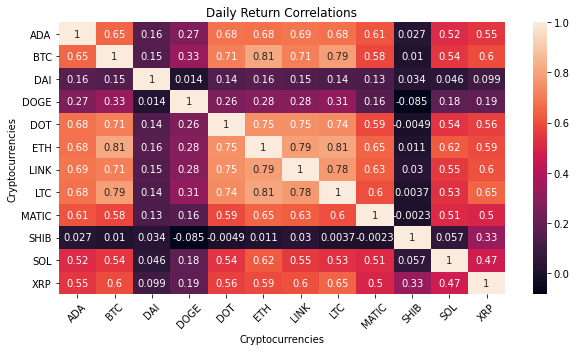

In [30]:
#Creating a heatmap

sns.heatmap(correlations, annot=True)

_=plt.xticks(rotation=45)
_=plt.ylabel('Cryptocurrencies')
_=plt.xlabel('Cryptocurrencies')
_=plt.title('Daily Return Correlations')

plt.show()